## Follows from NLP in NLP_Musixmatch notebook
### Sentiment analysis and TFIDF by decade
### Basic set-up for recommending by either sentiment or by lexical density (diversity)

In [1]:
# import things
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup  
import re
import string
import operator
from __future__ import division
import datetime
#import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

/Users/stephanie/anaconda3/envs/snakes/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# you might need to download the "vader" stuff!
#import nltk
#nltk.download()  # Download text data sets, including stop words

In [4]:
#read df from pickle file
lyrics_df = pd.read_pickle('CleanedLyricsDF_MaxRank_100')
print 'lyrics_df has ', len(lyrics_df), ' songs'
print lyrics_df.head(3)
#read hot100df from pickle file
hot100_df = pd.read_pickle('./Billboard100DF_cleaned')
print 'hot100_df has ', len(hot100_df), ' songs'

lyrics_df has  15868  songs
                        hot100 artist       hot100 track         track_name  \
0                        Ricky Nelson   Poor Little Fool   Poor Little Fool   
2                         Bobby Darin      Splish Splash      Splish Splash   
3  Elvis Presley With The Jordanaires  Hard Headed Woman  Hard Headed Woman   

                       artist_name        track_spotify_id  \
0                     Ricky Nelson  6kGo2CzDxnPP6pxbqABZ7l   
2                      Bobby Darin  4RxtXFzUxQCOBAbggjN7mM   
3  Elvis Presley & The Jordanaires                           

                                         lyrics_body       date  \
0  I used to play around with hearts\nThat hasten... 1958-09-13   
2  Splish splash, I was taking a bath\nLong about... 1958-09-06   
3  Well a hard headed woman\nA soft hearted man\n... 1958-09-06   

                           lyrics_clean_no_stopwords  lex_diversity  
0  used play around hearts hastened call met litt...       0.604167

### Begin Sentiment Analysis (vader)

In [5]:
## try sentiment analysis
# We will use the vader pre-trained analyzer to classify the songs as "positive" or "negative"
# nltk.sentiment.vader.SentimentIntensityAnalyzer.polarity_scores()
import nltk.sentiment.vader as vader


/Users/stephanie/anaconda3/envs/snakes/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
res = vader.SentiText('i hate cheese')

In [7]:
res.words_and_emoticons

['hate', 'cheese']

In [8]:
f = vader.SentimentIntensityAnalyzer()

In [9]:
f.polarity_scores('i hate cheese')

{'compound': -0.5719, 'neg': 0.787, 'neu': 0.213, 'pos': 0.0}

In [10]:
f.polarity_scores('i love cheese')

{'compound': 0.6369, 'neg': 0.0, 'neu': 0.192, 'pos': 0.808}

### Scores make sense for loving and hating cheese. Let's try on lyrics.

In [17]:
subset = lyrics_df[(lyrics_df['date']>datetime.date(2010,1,1)) & (lyrics_df['date']<datetime.date(2011,1,1))]
# try it on some lyrics
for i in range(5):
    print subset[['hot100 track']].iloc[i].values, ' by ' , subset[['hot100 artist']].iloc[i].values, ' Lyrics :'
    print  subset.lyrics_clean_no_stopwords.iloc[i]
    sent_dict = f.polarity_scores(subset.lyrics_clean_no_stopwords.iloc[i])
    print 'Positive Strength = ', sent_dict['pos'], ' Negative Strength = ', sent_dict['neg']

['Fearless']  by  ['Taylor Swift']  Lyrics :
something way street looks rained glow pavement walk car know want ask dance right middle parking lot yeah drivin road wonder know trying hard get caught cool run hands hair absentmindedly makin want know gets better take hand drag headfirst fearless know dance storm best dress fearless
Positive Strength =  0.371  Negative Strength =  0.053
['Imma Be']  by  ['The Black Eyed Peas']  Lyrics :
imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma imma next level imma rockin bass treble imma chillin mutha mutha crew imma makin deals wanna hah imma list flicks doin one handed flips imma sippin trick cause imma shakin hips gon lickin lips imma takin pics lookin fly shit imma flyest chick fly imma spreadin wings imma doin thing okay imma imma swing way imma imma imma imma swing way fergie ferg imma imma stay st century til infinity imma imma imma imma imma imma imma imma imma imma ri

## positive scores seem pretty reasonable...
## let's apply to all the songs in the database:

In [18]:
# make functions for getting positive, negative, and compound sentiments individually
def get_pos(text):
    res = f.polarity_scores(text)
    return res['pos']
def get_neg(text):
    res = f.polarity_scores(text)
    return res['neg']
def get_compound(text):
    res = f.polarity_scores(text)
    return res['compound']

## the cell below takes a couple minutes to run:

In [19]:
# add 3 sentiment columns to the dataframe:
lyrics_df['pos'] = lyrics_df.lyrics_clean_no_stopwords.map(get_pos)
lyrics_df['neg'] = lyrics_df.lyrics_clean_no_stopwords.map(get_neg)
lyrics_df['compound_sentiment'] = lyrics_df.lyrics_clean_no_stopwords.map(get_compound)

In [21]:
lyrics_df[['compound_sentiment']].iloc[0].values[0]

-0.9597

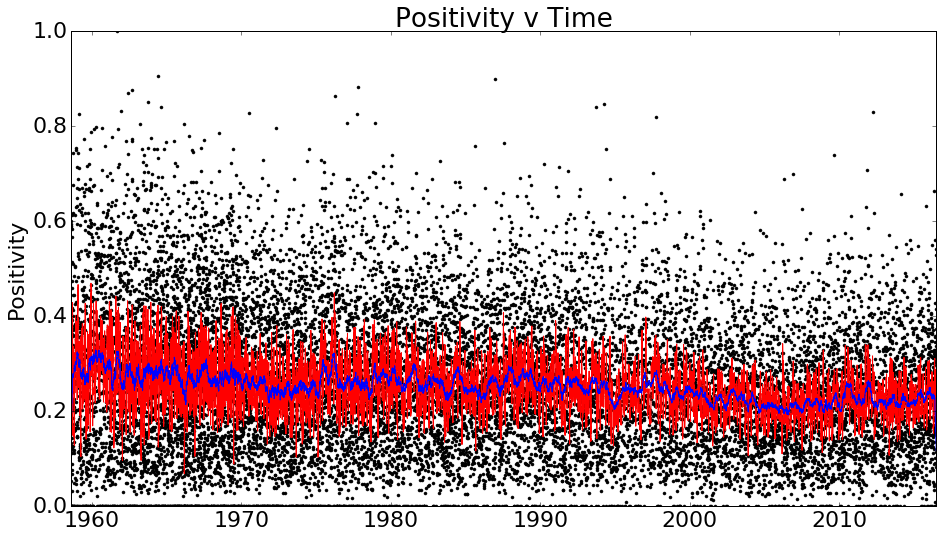

In [22]:
## plot positive sentiment as a funciton of time
matplotlib.rcParams.update({'font.size': 22})
# what if look at a smoothed time series
#(want to take annual averages as well, but this is easy)
def window(size):
    return np.ones(size)/float(size)
times = lyrics_df.sort_values('date').date.values
vals = lyrics_df.sort_values('date').pos.values
plt.plot(times,vals,'k.')
plt.plot(times,np.convolve(vals,window(10),'same'),'r')
plt.plot(times,np.convolve(vals,window(100),'same'),'b')

plt.ylabel('Positivity')
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
plt.title('Positivity v Time')

plt.savefig('Positivity')

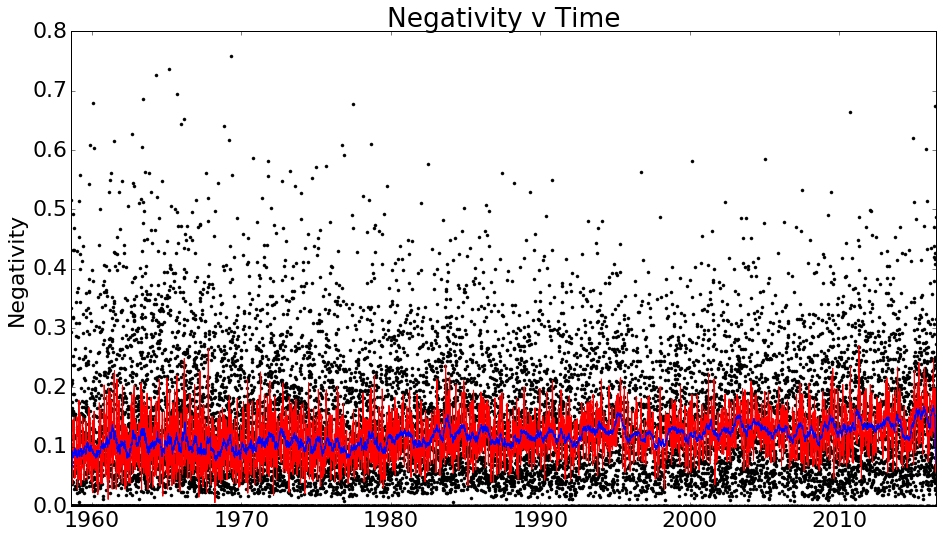

In [23]:
## plot positive sentiment as a funciton of time
matplotlib.rcParams.update({'font.size': 22})
# what if look at a smoothed time series
#(want to take annual averages as well, but this is easy)
def window(size):
    return np.ones(size)/float(size)
times = lyrics_df.sort_values('date').date.values
vals = lyrics_df.sort_values('date').neg.values
plt.plot(times,vals,'k.')
plt.plot(times,np.convolve(vals,window(10),'same'),'r')
plt.plot(times,np.convolve(vals,window(100),'same'),'b')

plt.ylabel('Negativity')
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
plt.title('Negativity v Time')
plt.savefig('Negativity')

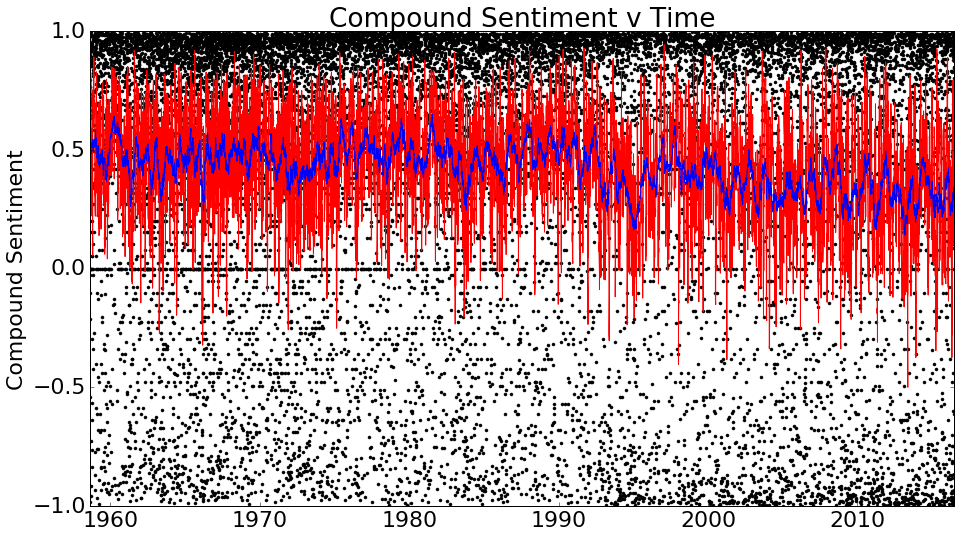

In [24]:
## plot positive sentiment as a funciton of time
matplotlib.rcParams.update({'font.size': 22})
# what if look at a smoothed time series
#(want to take annual averages as well, but this is easy)
def window(size):
    return np.ones(size)/float(size)
times = lyrics_df.sort_values('date').date.values
vals = lyrics_df.sort_values('date').compound_sentiment.values
plt.plot(times,vals,'k.')
plt.plot(times,np.convolve(vals,window(10),'same'),'r')
plt.plot(times,np.convolve(vals,window(100),'same'),'b')

plt.ylabel('Compound Sentiment')
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
plt.title('Compound Sentiment v Time')

### you could imagine building a recommender that uses just the criteria of lexical density or positivity, filters for more recent years, sorts by similarity of criteria, and says "you might like this more recent track":

## Simple Recommender! (Using lex_diversity only)

## The first step in the recommender will be to search the database for a user input of a song they like. Probably want to have the user input an artist too, in case there are multiple song title matches (for example, "The Sound of Silence" in the cell below gets 3 results
##  First search for exact matches, then do something like convert everything to lowercase and do a fuzzy match? A start is below, but the simplest thing for now is to just choose song titles that get exactly one matching song, such as:
>## Bohemian Rhapsody
>## Semi-Charmed Life
>## Creep
>## Lose Yourself

In [35]:
# here you can test if your song is in the database
#Example songs that are here: 'Bohemian Rhapsody', 'Creep','Semi-Charmed Life', 'Fearless', 'Lose Yourself'
song_i_like = 'The Sound of Silence' #oh no! this one has 3 matches, so you might want to add:
artist_i_like = 'Simon & Garfunkel'
#match == rows of lyrics_df matching your query
match = lyrics_df[lyrics_df['track_name']==song_i_like]
if len(match)==1:
    print 'Found 1 matching song!'
    print match[['hot100 track']].values, ' by ', match[['hot100 artist']].values
if len(match)==0:
    print 'No matching song! Try again.'
if len(match)>1:
    # use artist as well
    match = match[match['hot100 artist']==artist_i_like]
    print 'Found 1 matching song!'
    print match[['hot100 track']].values, ' by ', match[['hot100 artist']].values

Found 1 matching song!
[['The Sound Of Silence']]  by  [['Simon & Garfunkel']]


In [143]:
#recommend a song based on lexical density only
song_i_like = 'Creep'

#define similarity as diff between your song's lexical diversity & that of other songs
lex = lyrics_df[lyrics_df['track_name']==song_i_like].lex_diversity.values[0]
lyrics_df['dist'] = lyrics_df.lex_diversity.map((lambda x: abs(lex - x)))

#there will be some songs with identical lexical diversity to your song
print 'exact matches = ', len(lyrics_df[lyrics_df['dist']==0])

#recommend 5 songs based on lexical diversity
print 'You might like these recent tracks:'
lyrics_df[lyrics_df['date']>datetime.date(2013,1,1)].sort_values('dist')[:5]

exact matches =  52
You might like these recent tracks:


,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date,lyrics_clean_no_stopwords,lex_diversity,sentiment,pos,neg,compound,compound_sentiment,dist,dist2
244,Avicii,Wake Me Up!,Wake Me Up,Avicci,,Feeling my way through the darkness\nGuided by...,2014-01-11,feeling way darkness guided beating heart tell...,0.903226,"{u'neg': 0.178, u'neu': 0.537, u'pos': 0.285, ...",0.285,0.178,0.3400,0.3400,0.001536,0.3305
148,Luke Bryan,Play It Again,Play It Again,Luke Bryan,03fT3OHB9KyMtGMt2zwqCT,She was sittin' all alone over on the tailgate...,2014-06-07,sittin alone tailgate tan legs swingin georgia...,0.903226,"{u'neg': 0.052, u'neu': 0.641, u'pos': 0.308, ...",0.308,0.052,0.9607,0.9607,0.001536,0.2902
360,Jana Kramer,I Got The Boy,I Got the Boy,Jana Kramer,6tbNaE7kvGNqS7FvJ0dzLB,"I saw your picture in a paper, Honeymoon in Ja...",2015-12-26,saw picture paper honeymoon jamaica lucky girl...,0.906977,"{u'neg': 0.028, u'neu': 0.615, u'pos': 0.357, ...",0.357,0.028,0.9565,0.9565,0.002215,0.2860
346,Adele,Hello,Hello,Adele,193O4vZOZvdx7vrfZpfs37,"Hello,\nit's me\nI was wondering if after all ...",2016-02-13,hello wondering years like meet go everything ...,0.902439,"{u'neg': 0.07, u'neu': 0.804, u'pos': 0.126, u...",0.126,0.070,0.5574,0.5574,0.002323,0.1131
116,Randy Houser,We Went,We Went,Randy Houser,1wrZNOmdzrg0QZTvKSBZm3,Black pontiac with a pocket of cash\nFoot on t...,2016-02-20,black pontiac pocket cash foot gas ready throw...,0.901961,"{u'neg': 0.037, u'neu': 0.839, u'pos': 0.124, ...",0.124,0.037,0.5918,0.5918,0.002801,0.0787


## The following few cells use lexical density criterion only to recommend "recent" songs:

In [36]:
#recommend a song based on lexical density only
song_i_like = 'Semi-Charmed Life'

#define similarity as diff between your song's lexical diversity & that of other songs
lex = lyrics_df[lyrics_df['track_name']==song_i_like].lex_diversity.values[0]
lyrics_df['dist'] = lyrics_df.lex_diversity.map((lambda x: abs(lex - x)))

#there will be some songs with identical lexical diversity to your song
print 'exact matches = ', len(lyrics_df[lyrics_df['dist']==0])

#recommend 5 songs based on lexical diversity
print 'You might like these recent tracks:'
lyrics_df[lyrics_df['date']>datetime.date(2013,1,1)].sort_values('dist')[:5]

exact matches =  4
You might like these recent tracks:


,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date,lyrics_clean_no_stopwords,lex_diversity,pos,neg,compound_sentiment,dist
268,Drake,Back To Back,Back To Back,Drake,4rujbg8RNFitwtkv1qEq4K,"Oh man, oh man, oh man\n\nNot again\nYeah, I l...",2015-10-31,oh man oh man oh man yeah learned game william...,0.734940,0.151,0.188,-0.7096,0.000000
111,Empire Of The Sun,Walking On A Dream,Walking On a Dream,Empire of the Sun,0mBkoM8r7KAQzZij5swTUL,Walking on a dream\nHow can I explain\nTalking...,2016-02-20,walking dream explain talking see always runni...,0.735294,0.227,0.080,0.6288,0.000354
193,MAGIC!,Rude,Rude,MAGIC!,3tCwjWLicbjsMCvXhN0WOE,"Saturday morning, jumped out of bed\nAnd put o...",2014-09-27,saturday morning jumped bed put best suit got ...,0.735294,0.307,0.147,0.9212,0.000354
194,Kelsea Ballerini,Love Me Like You Mean It,Love Me Like You Mean It,Kelsea Ballerini,0knbW9EwgSLfNFMWys1mQm,"hey, boy with your hat back mmm i kinda like t...",2015-06-20,hey boy hat back mmm kinda like wanna walk way...,0.734375,0.411,0.084,0.9806,0.000565
149,Future Featuring Lil Wayne,Karate Chop (Remix),Karate Chop (remix),Future & Lil Wayne,,"You know, This just some real nigga shit, a re...",2013-05-04,know real nigga shit real nigga story know say...,0.736364,0.073,0.091,-0.6369,0.001424


In [37]:
#recommend a song based on lexical density only
song_i_like = 'Bohemian Rhapsody'

#define similarity as diff between your song's lexical diversity & that of other songs
lex = lyrics_df[lyrics_df['track_name']==song_i_like].lex_diversity.values[0]
lyrics_df['dist'] = lyrics_df.lex_diversity.map((lambda x: abs(lex - x)))

#there will be some songs with identical lexical diversity to your song
print 'exact matches = ', len(lyrics_df[lyrics_df['dist']==0])

#recommend 5 songs based on lexical diversity
print 'You might like these recent tracks:'
lyrics_df[lyrics_df['date']>datetime.date(2013,1,1)].sort_values('dist')[:5]

exact matches =  6
You might like these recent tracks:


,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date,lyrics_clean_no_stopwords,lex_diversity,pos,neg,compound_sentiment,dist
151,Young Money Featuring Drake,Trophies,Trophies,Young Money feat. Drake,0zCiXVyOOAlLrW84uBpGRx,Had hit records on my demo\nDid y'all boys not...,2014-05-31,hit records demo boys get memo stay interconti...,0.859649,0.217,0.215,-0.4236,0.000000
377,Hunter Hayes Featuring Jason Mraz,Everybody's Got Somebody But Me,Everybody's Got Somebody But Me,Hunter Hayes feat. Jason Mraz,,I wish the couple on the corner would just get...,2013-12-21,wish couple corner would get room seems like e...,0.860000,0.273,0.084,0.9189,0.000351
310,Kendrick Lamar Featuring MC Eiht,m.A.A.d City,m.A.A.d city,Kendrick Lamar feat. MC Eiht,0nfQguNoAfKFjsQHr6qnxc,If Pirus and Crips all got along\nThey'd proba...,2013-09-21,pirus crips got along probably gun end song se...,0.861878,0.121,0.289,-0.9928,0.002229
241,Brantley Gilbert Featuring Justin Moore & Thom...,Small Town Throwdown,Small Town Throwdown,Brantley Gilbert feat. Justin Moore & Thomas R...,0rX4YStqUt1k1VEBe1U4HJ,Aw son\n\nAround these parts ain't much to do\...,2014-09-06,aw son around parts much except work like dog ...,0.862069,0.154,0.064,0.6240,0.002420
163,The Band Perry,DONE.,Done.,The Band Perry,5w8Btq3MrCnXiN0QtmFMf8,You've been wearing that crown and tearing me ...,2013-06-08,wearing crown tearing since treated right stru...,0.862069,0.191,0.070,0.8118,0.002420


In [38]:
#recommend a song based on lexical density only
song_i_like = 'Lose Yourself'

#define similarity as diff between your song's lexical diversity & that of other songs
lex = lyrics_df[lyrics_df['track_name']==song_i_like].lex_diversity.values[0]
lyrics_df['dist'] = lyrics_df.lex_diversity.map((lambda x: abs(lex - x)))

#there will be some songs with identical lexical diversity to your song
print 'exact matches = ', len(lyrics_df[lyrics_df['dist']==0])

#recommend 5 songs based on lexical diversity
print 'You might like these recent tracks:'
lyrics_df[lyrics_df['date']>datetime.date(2013,1,1)].sort_values('dist')[:5]

exact matches =  1
You might like these recent tracks:


,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date,lyrics_clean_no_stopwords,lex_diversity,pos,neg,compound_sentiment,dist
259,Echosmith,Cool Kids,Cool Kids,Echosmith,13P5rwmk2EsoFRIz9UCeh9,"She says, ""I'm walkin' in a straight line""\nTh...",2014-10-11,says walkin straight line really style got hea...,0.680851,0.560,0.000,0.9867,0.000523
126,Trey Songz,Slow Motion,Slow Motion,Trey Songz,6LRLA7j6uPetzUzBIMAHQE,"I know you got all dressed up for the club,\nW...",2015-05-30,know got dressed club waiting come pick baby s...,0.680851,0.039,0.039,0.0000,0.000523
204,P!nk,Just Like Fire,Just Like Fire,P!nk,3AmiKNhylTZGpEXIm5AepY,I know that I'm running out of time\nI want it...,2016-06-11,know running time want mmm mmm wishing stop tr...,0.681319,0.303,0.126,0.9468,0.000991
197,Sia,Chandelier,Chandelier,Sia,3D4QFgYa3P9P0gjmv4eX6I,Party girls don't get hurt\nCan't feel anythin...,2014-11-01,party girls get hurt feel anything learn push ...,0.679245,0.297,0.110,0.9260,0.001083
276,Big Sean Featuring Lil Wayne & Jhene Aiko,Beware,Beware,Big Sean feat. Lil Wayne & Jhené Aiko,2VxlGxgtXBZViTR92zAwhV,When you said it was over\nYou shot right thro...,2013-10-19,said shot right heart let hoes tear right apar...,0.681416,0.138,0.185,-0.7716,0.001088


## Recommender using compound_sentiment only:

In [39]:
#recommend a song based on compound_sentiment only
song_i_like = 'Creep' #enter a song you like

#define similarity as diff between your song's sentiment and that of other songs
comp = lyrics_df[lyrics_df['track_name']==song_i_like].compound_sentiment.values[0]
lyrics_df['dist2'] = lyrics_df.compound_sentiment.map((lambda x: abs(comp - x)))

#recommend 5 songs based on compound sentiment
print 'exact matches = ', len(lyrics_df[lyrics_df['dist2']==0])
print 'You might like these recent tracks:'
lyrics_df[lyrics_df['date']>datetime.date(2013,1,1)].sort_values('dist2')[:5]

exact matches =  88
You might like these recent tracks:


,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date,lyrics_clean_no_stopwords,lex_diversity,pos,neg,compound_sentiment,dist,dist2
357,One Direction,Home,Home,One Direction,0uZzdkuzJEjFzaRR2HQ5mj,"Make a little conversation\nSo long, I've been...",2015-11-14,make little conversation long waiting let go f...,0.925000,0.216,0.126,0.6705,0.244672,0.0000
382,Missy Elliott Featuring Pharrell Williams,WTF (Where They From),WTF (Where They From),Missy Elliott feat. Pharrell Williams,,The dance you doing is dumb\nHow they do where...,2016-01-16,dance dumb stickin tongue girl know young bunc...,0.697248,0.171,0.138,0.6705,0.016920,0.0000
206,Rich Homie Quan,Flex (Ooh Ooh Ooh),"Flex (Ooh, Ooh, Ooh)",Rich Homie Quan,2LLFl56eIFGFlnrplUC26f,"Aye, oh, there it is, there it is, there it is...",2015-08-08,aye oh rich homie baby walked pocket niggas li...,0.674419,0.211,0.142,0.6705,0.005909,0.0000
183,Carrie Underwood,Little Toy Guns,Little Toy Guns,Carrie Underwood,4lnnde7PnrXR3pUzQKBe6X,"""Little Toy Guns""\n\nIn between the coats in t...",2015-06-06,little toy guns coats closet held heart shaped...,0.830508,0.260,0.205,0.6743,0.150181,0.0038
358,Travie McCoy Featuring Jason Mraz,Rough Water,Rough Water,Travie McCoy feat. Jason Mraz,,"Hey oh, never let go of me (Never let go)\nHol...",2013-11-23,hey oh never let go never let go hold tight go...,0.590476,0.129,0.108,0.6664,0.089852,0.0041


In [40]:
#recommend a song based on compound_sentiment only
song_i_like = 'Bohemian Rhapsody' #enter a song you like

#define similarity as diff between your song's sentiment and that of other songs
comp = lyrics_df[lyrics_df['track_name']==song_i_like].compound_sentiment.values[0]
lyrics_df['dist2'] = lyrics_df.compound_sentiment.map((lambda x: abs(comp - x)))

#recommend 5 songs based on compound sentiment
print 'exact matches = ', len(lyrics_df[lyrics_df['dist2']==0])
print 'You might like these recent tracks:'
lyrics_df[lyrics_df['date']>datetime.date(2013,1,1)].sort_values('dist2')[:5]

exact matches =  1
You might like these recent tracks:


,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date,lyrics_clean_no_stopwords,lex_diversity,pos,neg,compound_sentiment,dist,dist2
182,Nico & Vinz,Am I Wrong,Am I Wrong,Nico & Vinz,08SxltHeEkQqgx5foDRRqO,Am I wrong\nFor thinking out the box from wher...,2014-08-16,wrong thinking box stay wrong saying choose an...,0.723404,0.105,0.216,-0.8555,0.043076,0.0008
51,Yo Gotti,Down In The DM,Down In the DM,Yo Gotti,54KbpaNkWhOLwonw3lhwxY,"I see your girl post her bm, so I hit her in h...",2016-01-23,see girl post bm hit dm eyes yeah see em yeah ...,0.603448,0.093,0.197,-0.8591,0.076880,0.0028
110,Hoodie Allen Featuring Ed Sheeran,All About It,All About It,Hoodie Allen feat. Ed Sheeran,58hb0g5ctZ2XyZyvbZM2n2,Cause I got soul and I won't quit\nAnd your da...,2015-02-07,cause got soul quit dad like talk shit cause b...,0.865169,0.156,0.236,-0.8591,0.184841,0.0028
178,T-Wayne,Nasty Freestyle,Nasty Freestyle,T-Wayne,,First let me hop out motherfucking Porsche\nI ...,2015-07-11,first let hop motherfucking porsche want ass s...,0.909091,0.174,0.260,-0.8591,0.228763,0.0028
116,A$AP Rocky Featuring Skrillex,Wild For The Night,Wild for the Night,A$AP Rocky feat. Skrillex,,"Wake up falling blessed up, pistol on that dre...",2013-05-25,wake falling blessed pistol dresser afraid sho...,0.771186,0.196,0.248,-0.8500,0.090859,0.0063


## Baggin' and TFIDF'n

## First just by decade to see if any interesting features pop up

In [41]:
#if we want to do tf-idf to see what words are unique in particular decades, we need to make a new
# dataframe with only 50 60 70 80 90 00 10 (7 rows, one for each decade), and all the lyrics from that decade in
# each row
decades_lyrics = []
y = 1950
decades = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
for y in decades:
#    print y, '\'s'
    start_date = datetime.date(year=y,month=1,day=1)
    end_date = datetime.date(year=y+10,month=1,day=1)
    subset = lyrics_df[(lyrics_df['date'] > start_date) & (lyrics_df['date'] < end_date) ]
    lyrics = subset.lyrics_clean_no_stopwords
    lyrics = string.join(lyrics) #join all the words into one string
    decades_lyrics.append(lyrics)


In [42]:
len(decades_lyrics)
#decades_lyrics[0]

7

## The cell below takes a minute to run! (Makes BoW feature arrays for documents = all lyrics per decade)

In [43]:
# make bag-of-words arrays for each decade, both raw and tfidf-weighted
transformer = TfidfTransformer() #to do tfidf weighting on all of the bag_of_words vectors

all3_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(1,3)) 
all3_features = all3_vec.fit_transform(decades_lyrics).toarray()
tfidf_all3 = transformer.fit_transform(all3_features)
tfidf_all3 = tfidf_all3.toarray()

bigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(2,2))
bigram_features = bigram_vec.fit_transform(decades_lyrics).toarray()
tfidf_bigram = transformer.fit_transform(bigram_features)
tfidf_bigram = tfidf_bigram.toarray()

trigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(3,3)) 
trigram_features = trigram_vec.fit_transform(decades_lyrics).toarray()
tfidf_trigram = transformer.fit_transform(trigram_features)
tfidf_trigram = tfidf_trigram.toarray()

In [44]:
np.shape(all3_features)

(7, 5000)

In [45]:
# get the overall common features in our corpus
n=20
#all3
vocab = all3_vec.get_feature_names()
word_features = all3_features
# Sum up the counts of each vocabulary word
dist = np.sum(word_features, axis=0)
count_dict = dict(zip(vocab, dist))
#sort dict by counts to see most frequent words
sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
#look at just the top 50 most frequent features
print n, ' most frequent features (all3):'
print sorted_count_dict[:n]
top_20_overall = sorted_count_dict[:20]
#bigram
vocab = bigram_vec.get_feature_names()
word_features = bigram_features
# Sum up the counts of each vocabulary word
dist = np.sum(word_features, axis=0)
count_dict = dict(zip(vocab, dist))
#sort dict by counts to see most frequent words
sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
#look at just the top 50 most frequent features
print n, ' most frequent features (bigram):'
print sorted_count_dict[:n]
top_20_overall_bigram = sorted_count_dict[:20]
#trigram
vocab = trigram_vec.get_feature_names()
word_features = trigram_features
# Sum up the counts of each vocabulary word
dist = np.sum(word_features, axis=0)
count_dict = dict(zip(vocab, dist))
#sort dict by counts to see most frequent words
sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
#look at just the top 50 most frequent features
print n, ' most frequent features (trigram):'
print sorted_count_dict[:n]
top_20_overall_trigram = sorted_count_dict[:20]

20  most frequent features (all3):
[(u'love', 13429), (u'know', 10302), (u'like', 9819), (u'got', 8329), (u'oh', 8227), (u'baby', 7740), (u'get', 7434), (u'yeah', 6261), (u'one', 5629), (u'go', 5540), (u'let', 5496), (u'time', 5299), (u'see', 4864), (u'never', 4809), (u'girl', 4673), (u'make', 4630), (u'say', 4611), (u'want', 4497), (u'come', 4489), (u'way', 4483)]
20  most frequent features (bigram):
[(u'oh oh', 2145), (u'yeah yeah', 1472), (u'la la', 1469), (u'na na', 963), (u'let go', 810), (u'love love', 772), (u'hey hey', 677), (u'ooh ooh', 654), (u'oh yeah', 640), (u'da da', 535), (u'baby baby', 454), (u'know know', 454), (u'feel like', 437), (u'doo doo', 429), (u'get get', 423), (u'every time', 390), (u'oh baby', 388), (u'ah ah', 386), (u'every day', 354), (u'know love', 352)]
20  most frequent features (trigram):
[(u'oh oh oh', 1185), (u'la la la', 1182), (u'na na na', 787), (u'yeah yeah yeah', 738), (u'ooh ooh ooh', 399), (u'da da da', 367), (u'doo doo doo', 312), (u'hey hey h

### convert dicts to lists of top 20 features, we'll use these lists later to filter words common to all decades (to let more decade-specific words come through

In [46]:
top_20_overall = [str(i[0]) for i in top_20_overall]
top_20_overall_bigram = [str(i[0]) for i in top_20_overall_bigram]
top_20_overall_trigram = [str(i[0]) for i in top_20_overall_trigram]

## Most common unigrams (+2 +3-grams) (Raw Counts) (By Decade)

In [47]:
n=20
for i in range(len(decades)):
    print str(decades[i])+'\'s'
    vocab = all3_vec.get_feature_names()
    dist = all3_features[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    print n, ' most frequent features:'
    print sorted_count_dict[:n]

1950's
20  most frequent features:
[(u'love', 305), (u'oh', 215), (u'baby', 131), (u'know', 117), (u'got', 107), (u'never', 101), (u'well', 100), (u'like', 96), (u'little', 94), (u'come', 93), (u'girl', 87), (u'say', 85), (u'yeah', 84), (u'gonna', 82), (u'way', 79), (u'one', 77), (u'heart', 77), (u'pretty', 76), (u'time', 74), (u'la', 74)]
1960's
20  most frequent features:
[(u'love', 2797), (u'baby', 1562), (u'oh', 1513), (u'know', 1377), (u'got', 1089), (u'yeah', 1062), (u'like', 942), (u'one', 866), (u'little', 851), (u'come', 829), (u'girl', 820), (u'go', 809), (u'let', 774), (u'see', 761), (u'time', 759), (u'get', 742), (u'say', 738), (u'heart', 706), (u'never', 676), (u'way', 645)]
1970's
20  most frequent features:
[(u'love', 2629), (u'know', 1493), (u'oh', 1395), (u'baby', 1392), (u'got', 1351), (u'get', 1184), (u'like', 1141), (u'time', 935), (u'let', 909), (u'yeah', 881), (u'come', 841), (u'one', 821), (u'way', 798), (u'gonna', 780), (u'go', 769), (u'make', 745), (u'never', 7

## Most common bigrams (Raw Counts) (By Decade)

In [115]:
n=12
for i in range(len(decades)):
    print str(decades[i])+'\'s'
    vocab = bigram_vec.get_feature_names()
    dist = bigram_features[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    print n, ' most frequent features:'
    print sorted_count_dict[:n]

1950's
12  most frequent features:
[(u'oh oh', 63), (u'na na', 56), (u'la la', 55), (u'da da', 38), (u'yeah yeah', 37), (u'cha cha', 36), (u'love love', 29), (u'pretty girl', 27), (u'ooh ooh', 26), (u'bom bom', 23), (u'hey hey', 22), (u'ah ah', 20)]
1960's
12  most frequent features:
[(u'yeah yeah', 359), (u'la la', 344), (u'oh oh', 292), (u'love love', 162), (u'oh yeah', 154), (u'hey hey', 139), (u'little girl', 121), (u'da da', 104), (u'ba ba', 102), (u'oop oop', 102), (u'ah ah', 101), (u'ooh ooh', 99)]
1970's
12  most frequent features:
[(u'la la', 254), (u'yeah yeah', 207), (u'doo doo', 196), (u'oh oh', 190), (u'ooh ooh', 170), (u'love love', 168), (u'hey hey', 120), (u'oh yeah', 118), (u'get get', 116), (u'oh baby', 97), (u'baby baby', 95), (u'rock roll', 93)]
1980's
12  most frequent features:
[(u'oh oh', 319), (u'yeah yeah', 213), (u'let go', 157), (u'ooh ooh', 156), (u'love love', 110), (u'na na', 109), (u'oh yeah', 80), (u'oh baby', 77), (u'know love', 75), (u'every time', 68)

## Most common tri-grams (Raw Counts) (By Decade)

In [116]:
n=12
for i in range(len(decades)):
    print str(decades[i])+'\'s'
    vocab = trigram_vec.get_feature_names()
    dist = trigram_features[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    print n, ' most frequent features:'
    print sorted_count_dict[:n]

1950's
12  most frequent features:
[(u'na na na', 53), (u'la la la', 50), (u'da da da', 34), (u'oh oh oh', 30), (u'cha cha cha', 22), (u'yeah yeah yeah', 21), (u'bom bom bom', 19), (u'ooh ooh ooh', 19), (u'dooby doom dooby', 16), (u'pretty girl pretty', 15), (u'ah ah ah', 13), (u'girl pretty girl', 12)]
1960's
12  most frequent features:
[(u'la la la', 270), (u'yeah yeah yeah', 203), (u'oh oh oh', 139), (u'ah ah ah', 77), (u'da da da', 76), (u'oop oop oop', 76), (u'ba ba ba', 75), (u'ooh ooh ooh', 63), (u'na na na', 63), (u'hey hey hey', 60), (u'batman batman batman', 57), (u'doo doo doo', 54)]
1970's
12  most frequent features:
[(u'la la la', 197), (u'doo doo doo', 152), (u'ooh ooh ooh', 112), (u'yeah yeah yeah', 93), (u'oh oh oh', 73), (u'get get get', 61), (u'love love love', 47), (u'na na na', 47), (u'ah ah ah', 45), (u'hey hey hey', 42), (u'oo oo oo', 37), (u'nah nah nah', 33)]
1980's
12  most frequent features:
[(u'oh oh oh', 159), (u'yeah yeah yeah', 118), (u'na na na', 93), (u'

## Interesting thing to do for visualization: Plot time series of certain words (maybe get frequencies of words annually instead of decadally, and plot as time series, like google trends). You'll see the arrival of explicit words in popular music + maybe other interesting things, like love becoming less ubiquitous.

## TFIDF

### TFIDF all 3 (uni+ 2- + 3-grams)

In [48]:
# tfidf now...
n=20
for i in range(len(decades)):
    vocab = all3_vec.get_feature_names()
    print str(decades[i])+'\'s'
    dist = tfidf_all3[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    print n, ' most frequent features:'
    print sorted_count_dict[:n]

1950's
20  most frequent features:
[(u'love', 0.42515280595661525), (u'oh', 0.29969787960876154), (u'baby', 0.18260661501743147), (u'know', 0.16309140425220978), (u'got', 0.14915196799133715), (u'never', 0.14078830623481356), (u'well', 0.13939436260872631), (u'like', 0.13381858810437725), (u'little', 0.13103070085220273), (u'come', 0.12963675722611548), (u'girl', 0.12127309546959189), (u'say', 0.11848520821741736), (u'yeah', 0.1170912645913301), (u'gonna', 0.11430337733915558), (u'way', 0.11012154646089378), (u'one', 0.10733365920871926), (u'heart', 0.10733365920871926), (u'pretty', 0.10593971558263199), (u'time', 0.10315182833045747), (u'la', 0.10315182833045747)]
1960's
20  most frequent features:
[(u'love', 0.44071798282248287), (u'baby', 0.24612137617758964), (u'oh', 0.23840053915281251), (u'know', 0.21697127720649229), (u'got', 0.17159166367310827), (u'yeah', 0.16733732490435352), (u'like', 0.14842915259877684), (u'one', 0.13645397680524496), (u'little', 0.13409045526704788), (u'c

### The TFIDF-weighted features are very similar to the non-weighted one, let's only print them if they aren't in the top 20 overall words!

In [49]:
# tfidf now...
n=20
for i in range(len(decades)):
    decade_words = []
    vocab = all3_vec.get_feature_names()
    print str(decades[i])+'\'s'
    dist = tfidf_all3[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    top_50 = sorted_count_dict[:50]
    top_50 = [str(i[0]) for i in top_50]
    for word in top_50:
        if word not in top_20_overall:
            decade_words.append(word)
    print decade_words

1950's
['well', 'little', 'gonna', 'heart', 'pretty', 'la', 'said', 'true', 'oh oh', 'na', 'tell', 'day', 'da', 'night', 'na na', 'la la', 'na na na', 'ooh', 'cha', 'right', 'long', 'la la la', 'take', 'cha cha', 'home', 'every', 'around', 'ah', 'hey', 'man', 'mine']
1960's
['little', 'heart', 'tell', 'gonna', 'day', 'man', 'cause', 'good', 'away', 'well', 'night', 'hey', 'right', 'la', 'said', 'take', 'every', 'world', 'back', 'long', 'around', 'look', 'could', 'need', 'wanna', 'yeah yeah', 'la la', 'home', 'life', 'eyes']
1970's
['gonna', 'man', 'day', 'night', 'right', 'feel', 'cause', 'take', 'good', 'away', 'well', 'life', 'ooh', 'said', 'back', 'need', 'tell', 'little', 'hey', 'long', 'heart', 'wanna', 'could', 'around', 'world', 'keep', 'home', 'think', 'people', 'mind']
1980's
['night', 'heart', 'feel', 'gonna', 'take', 'right', 'tell', 'away', 'could', 'cause', 'need', 'back', 'day', 'wanna', 'well', 'eyes', 'life', 'ooh', 'give', 'little', 'think', 'good', 'said', 'look', 'wo

## TFIDF Bigrams Only:

In [50]:
# tfidf now...
n=20
for i in range(len(decades)):
    vocab = bigram_vec.get_feature_names()
    print str(decades[i])+'\'s'
    dist = tfidf_bigram[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    print n, ' most frequent features:'
    print sorted_count_dict[:n]

1950's
20  most frequent features:
[(u'oh oh', 0.33849451252439572), (u'na na', 0.30088401113279617), (u'la la', 0.29551108236256768), (u'cha cha', 0.24907046594341092), (u'dooby doom', 0.23078501328771192), (u'doom dooby', 0.20514223403352172), (u'da da', 0.20417129326868313), (u'yeah yeah', 0.19879836449845462), (u'love love', 0.1558149343366266), (u'pretty girl', 0.14506907679616959), (u'ooh ooh', 0.13969614802594107), (u'hula hoop', 0.13645738797992707), (u'bom bom', 0.12357736171525557), (u'hey hey', 0.11820443294502707), (u'really mine', 0.10916591038394166), (u'ah ah', 0.10745857540457007), (u'girl pretty', 0.10353651833362114), (u'kansas city', 0.10006875118527984), (u'pretty pretty', 0.097446134902231654), (u'pretty baby', 0.089942112701787272)]
1960's
20  most frequent features:
[(u'yeah yeah', 0.34852961921152448), (u'la la', 0.33396710030296495), (u'oh oh', 0.2834837014199586), (u'oop oop', 0.19615187147095539), (u'love love', 0.15727520421244279), (u'oh yeah', 0.1495085274

In [51]:
## again tfidf doesn't change the order much, so let's exclude top 20 again
n=20
for i in range(len(decades)):
    decade_words = []
    vocab = bigram_vec.get_feature_names()
    print str(decades[i])+'\'s'
    dist = tfidf_bigram[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    top_50 = sorted_count_dict[:50]
    top_50 = [str(i[0]) for i in top_50]
    for word in top_50:
        if word not in top_20_overall_bigram:
            decade_words.append(word)
    print decade_words

1950's
['cha cha', 'dooby doom', 'doom dooby', 'pretty girl', 'hula hoop', 'bom bom', 'really mine', 'girl pretty', 'kansas city', 'pretty pretty', 'pretty baby', 'yi yi', 'come home', 'burn burn', 'bye bye', 'baby bye', 'love true', 'rock roll', 'never gonna', 'high school', 'little girl', 'gonna tell', 'new pair', 'doo wah', 'la da', 'pretty little', 'true love', 'mine mine', 'love oh', 'last night', 'bah bah', 'goodbye baby', 'dooby dooby', 'uh huh', 'see baby']
1960's
['oop oop', 'batman batman', 'little girl', 'bird bird', 'ba ba', 'little bit', 'alley oop', 'last night', 'ha ha', 'dee dum', 'come back', 'yeah oh', 'long time', 'dum dum', 'come baby', 'oom mow', 'dum dee', 'hitch hike', 'um um', 'monkey monkey', 'love like', 'baby love', 'oh yes', 'come come', 'true love', 'never never', 'love oh', 'one day', 'dah dah', 'hold tight', 'well bird', 'papa oom']
1970's
['rock roll', 'love baby', 'come come', 'make feel', 'let know', 'baby love', 'chh chh', 'know got', 'aah aah', 'come

## TFIDF Trigrams only:

In [52]:
# tfidf now...
n=20
for i in range(len(decades)):
    vocab = trigram_vec.get_feature_names()
    print str(decades[i])+'\'s'
    dist = tfidf_trigram[i] #one row of word features
    count_dict = dict(zip(vocab, dist))
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    print n, ' most frequent features:'
    print sorted_count_dict[:n]

1950's
20  most frequent features:
[(u'na na na', 0.32703239893448227), (u'la la la', 0.3085211310702663), (u'dooby doom dooby', 0.23559111531497831), (u'da da da', 0.2097943691277811), (u'cha cha cha', 0.19955196024380795), (u'oh oh oh', 0.1851126786421598), (u'pretty girl pretty', 0.18333830447887453), (u'doom dooby doom', 0.14724444707186146), (u'yi ya yi', 0.14724444707186146), (u'la da dada', 0.14724444707186146), (u'bom bom bom', 0.13289298719534529), (u'tcha come home', 0.13252000236467532), (u'bom ba bom', 0.13252000236467532), (u'yeah yeah yeah', 0.12957887504951185), (u'girl pretty girl', 0.12536920397154883), (u'oh yi yi', 0.11779555765748916), (u'yi yi ya', 0.11779555765748916), (u'wow oh yi', 0.11779555765748916), (u'really mine really', 0.11779555765748916), (u'ooh ooh ooh', 0.1172380298067012)]
1960's
20  most frequent features:
[(u'la la la', 0.42724631308640093), (u'yeah yeah yeah', 0.32122593169088659), (u'oop oop oop', 0.28698035387880733), (u'oh oh oh', 0.2199527315

## Now let's make our BoW features for each song (instead of each decade).

## Then these features will go into our recommender!!

In [53]:
# We can use the CountVectorizers defined previously -- all3_vec, bigram_vec, and trigram_vec
# But when we run fit_transform, this time we will input the cleaned lyrics column of the dataframe,
# such that each song will have it's own feature vector.
bow_all3 = all3_vec.fit_transform(lyrics_df.lyrics_clean_no_stopwords)
#bow_bigram = bigram_vec.fit_transform(lyrics_df.lyrics_clean_no_stopwords).toarray()
#bow_trigram = trigram_vec.fit_transform(lyrics_df.lyrics_clean_no_stopwords).toarray()
# Numpy arrays are easy to work with, so convert the result to an array
# omit the "toarray()" above if you want to preserve sparse format
print('done!')

done!


In [54]:
bow_all3_array = bow_all3.toarray()

In [55]:
#that takes some time to run! probably because there are many songs!
print np.shape(bow_all3)
#print 'bow_all3 has ', np.shape(bow_all3)[0], ' songs , each with ', np.shape(bow_all3)[1], ' word:count features ' 

(15868, 5000)


In [56]:
bow_all3

<15868x5000 sparse matrix of type '<type 'numpy.int64'>'
	with 568360 stored elements in Compressed Sparse Row format>

## To Do : FIgure out how to put the bag of words array into the database (lyrics_df)
## The for-loop below takes forever -- is there a better way?
## How big does the file become when we add 16,000 rows of 5000 numbers to it?

In [59]:
lyrics_df["BoW_array"] = np.nan #add a row for the bag of words
# rather than run for all the rows, try just running for 10 rows. all rows takes forever!
#for i in range(len(lyrics_df)):
for i in range(10):
    lyrics_df['BoW_array'].iloc[i] = bow_all3[i][:]

/Users/stephanie/anaconda3/envs/snakes/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [65]:
lyrics_df.BoW_array.head(11) #see the sparse format vectors are only in the top 10 rows

0       (0, 4546)\t1\n  (0, 3245)\t1\n  (0, 99)\t2\n...
2       (0, 99)\t1\n  (0, 4177)\t1\n  (0, 2441)\t1\n...
3       (0, 3012)\t2\n  (0, 4932)\t2\n  (0, 3049)\t2...
4       (0, 2405)\t1\n  (0, 2072)\t1\n  (0, 754)\t1\...
6       (0, 1317)\t1\n  (0, 208)\t1\n  (0, 2271)\t1\...
8       (0, 2405)\t1\n  (0, 3351)\t1\n  (0, 2132)\t1...
11      (0, 2317)\t1\n  (0, 2132)\t1\n  (0, 754)\t2\...
12      (0, 2122)\t1\n  (0, 3012)\t3\n  (0, 3249)\t1...
13      (0, 4891)\t2\n  (0, 3012)\t2\n  (0, 1143)\t1...
14      (0, 3012)\t1\n  (0, 1106)\t1\n  (0, 754)\t1\...
15                                                  NaN
Name: BoW_array, dtype: object